In [1]:
# Argparse
import argparse
opt = argparse.Namespace( # Fake parsed arguments
    seed=7,
    device=-1,
    cuda=False,
    visdom=True
)

# Util
import cdae.util as util
util.init(opt)

# Model
import cdae.models.quadratic as quadratic


# Torch
import torch
from torch.autograd import Variable
import torch.optim as optim

# Plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.available
plt.style.use('seaborn-whitegrid')

%matplotlib notebook

# Stats
import scipy.stats

# Generative Model

The true generative model $p$ over latents $k, x$ and observed variables $y$ is:
\begin{align}
    k &\sim \mathrm{Categorical}([10, 20], [0.5, 0.5]) \\\
    x &\sim \mathrm{Normal}(0, 1) \\\
    y &\sim \mathrm{Normal}(f(k, x) ,1)
\end{align}
where $f: \mathbb R^2 \to \mathbb R$ is defined as
\begin{align}
    f(k, x) = a(k + x)^2 + b(k + x) + c.
\end{align}


<IPython.core.display.Javascript object>


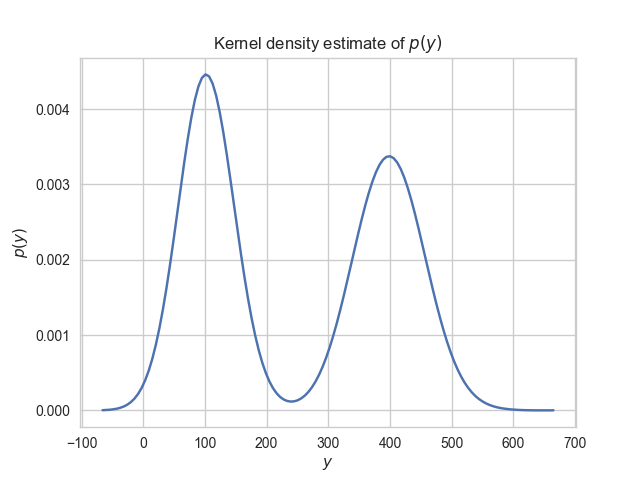

In [2]:
generative_model = quadratic.GenerativeModel()
num_data = 1000
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$')

# Generative Network

Assume that we actually don't know the form of $f$ and that we want to learn it, i.e. the true model $p$ from a dataset $(y^{(n)})_{n = 1}^N$.
Let's model the family of functions $f$ under consideration as a neural network parameterized by generative weights $\theta$ such that it maps from $\mathbb R^2$ to $\mathbb R$:

<IPython.core.display.Javascript object>


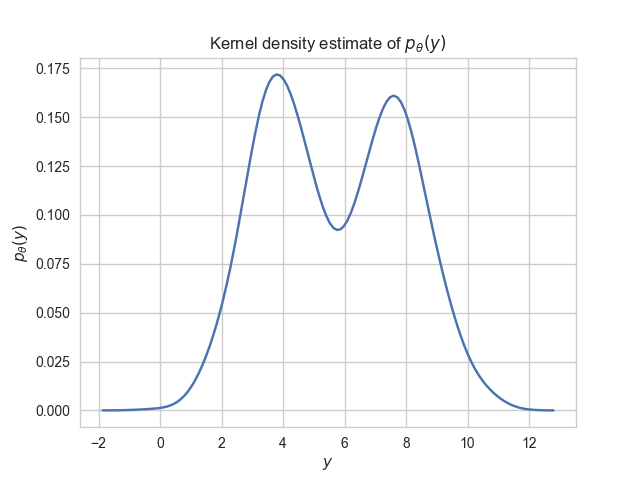

In [3]:
generative_network = quadratic.GenerativeNetwork()
num_data = 1000
_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()

fig, ax = plt.subplots()
sns.kdeplot(y, ax=ax)
ax.set_title('Kernel density estimate of $p_{\\theta}(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p_{\\theta}(y)$')

# Inference Network

We seek to learn an inference network $q_{\phi}(k, x \lvert y)$ parameterized by $\phi$ which, given $y$ maps to the parameters of the distribution over $(k, x)$, ideally close to the posterior under the true model, $p(k, x \lvert y)$.

Let
\begin{align}
    q_{\phi}(k, x \lvert y) &= q_{\phi}(k \lvert y) q_{\phi}(x \lvert k, y) \\\
    q_{\phi}(k \lvert y) &= \mathrm{Categorical}([10, 20], [\phi_1, \phi_2]) \\\
    q_{\phi}(x \lvert k, y) &= \mathrm{Normal}(\phi_3, \phi_4)
\end{align}
where $\phi = [\phi_1, \dotsc, \phi_4]$ is the output of the inference network.

In [4]:
inference_network = quadratic.InferenceNetwork()
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test

107.20196533203125

<IPython.core.display.Javascript object>


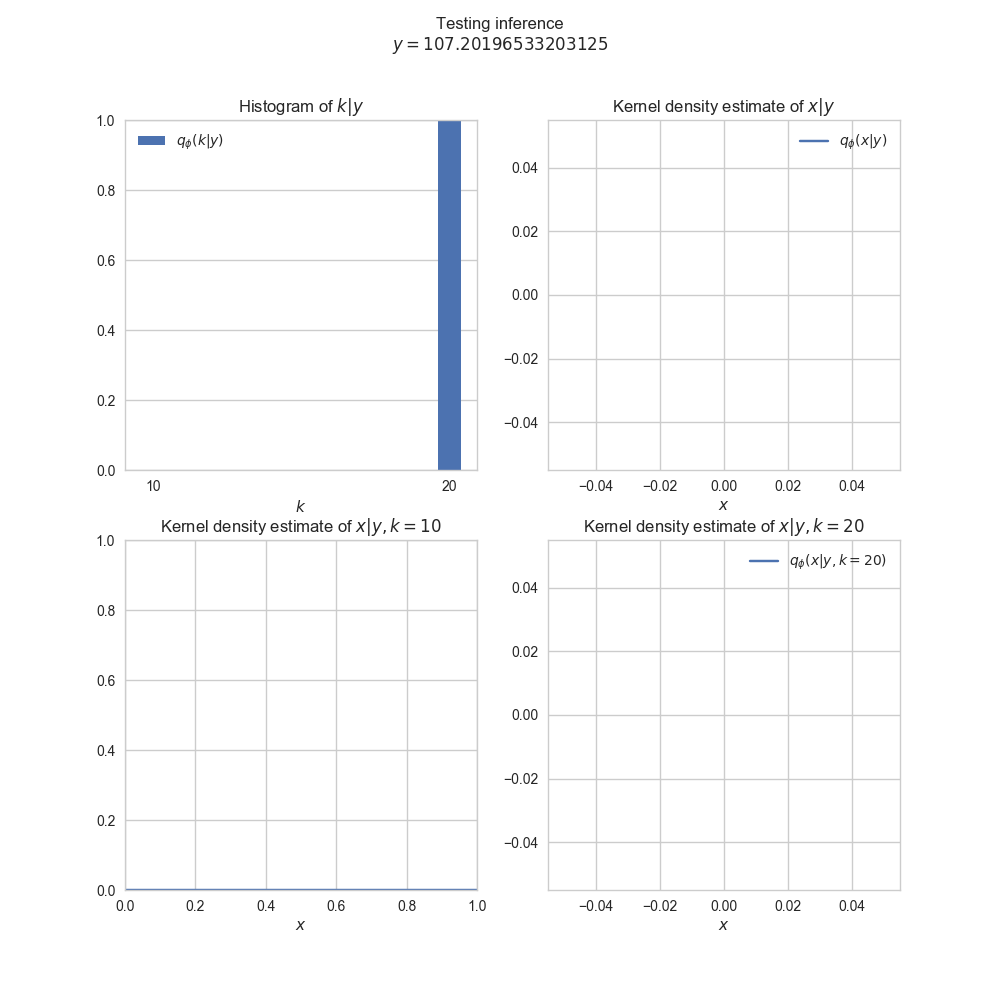

/Users/tuananhle/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/tuananhle/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


In [5]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [10, 20]
normalized_weights = [
    torch.sum(k == 10) / len(k),
    torch.sum(k == 20) / len(k),
]
bar1 = ax[0][0].bar(np.array(values), normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 10]) != 0:
    sns.kdeplot(x[k == 10].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 10)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 10)$', color=colors[0])

if len(x[k == 20]) != 0:
    sns.kdeplot(x[k == 20].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 20)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 20)$', color=colors[0])

##############
##############
##############

ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 10$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 20$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()

# Training Loop

In [6]:
inference_network = quadratic.InferenceNetwork()
generative_network = quadratic.GenerativeNetwork()

inference_network_optim = optim.Adam(inference_network.parameters())
generative_network_optim = optim.Adam(generative_network.parameters())

num_iterations = 2
batch_size = 50
num_data = 100
generative_epochs_per_iteration = 10
inference_epochs_per_iteration = 10
num_generative_epochs = np.repeat(generative_epochs_per_iteration, num_iterations)
num_inference_epochs = np.repeat(inference_epochs_per_iteration, num_iterations)

data_generator = lambda: generative_model.sample(1)[2][0][0]
quadratic_dataset = quadratic.Dataset(infinite_data=False, num_data=num_data, data_generator=data_generator)
quadratic_dataloader = torch.utils.data.DataLoader(quadratic_dataset, batch_size=batch_size, shuffle=True)

generative_network_objective = []
inference_network_objective = []
if opt.visdom:
    util.vis.close()
    generative_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to maximize)',
            title='Generative network objective'
        )
    )
    
    inference_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to minimize)',
            title='Inference network objective'
        )
    )

for i in range(num_iterations):
    util.logger.info('Iteration {}'.format(i))
    
    # Step 1
    for epoch in range(num_generative_epochs[i]):
        util.logger.info('Generative network step | Epoch {}'.format(epoch))
        temp_generative_network_objective = []
        for _, y in enumerate(quadratic_dataloader):
            k, x = inference_network.sample(y.unsqueeze(1))
            
            generative_network_optim.zero_grad()
            logpdf_generative_network = generative_network.forward(Variable(k), Variable(x), Variable(y))
            temp_generative_network_objective += logpdf_generative_network.data.numpy().tolist()
            utility = torch.mean(logpdf_generative_network)
            loss = -utility # we want to maximize
            loss.backward()
            generative_network_optim.step()
        generative_network_objective.append(np.mean(temp_generative_network_objective))
        
        util.vis.line(
            X=np.arange(len(generative_network_objective)),
            Y=np.nan_to_num(np.array(generative_network_objective)),
            update='replace',
            win=generative_network_objective_line
        )
    
    # Step 2
    for epoch in range(num_inference_epochs[i]):
        util.logger.info('Inference network step | Epoch {}'.format(epoch))
        temp_inference_network_objective = []
        for batch_size in util.chunk(num_data, batch_size):
            k, x, y = generative_network.sample(batch_size)
            
            inference_network_optim.zero_grad()
            logpdf_inference_network = inference_network.forward(Variable(k), Variable(x), Variable(y))
            temp_inference_network_objective += logpdf_inference_network.data.numpy().tolist()
            loss = torch.mean(logpdf_inference_network)
            loss.backward()
            inference_network_optim.step()
        inference_network_objective.append(np.mean(temp_inference_network_objective))
        util.vis.line(
            X=np.arange(len(inference_network_objective)),
            Y=np.nan_to_num(np.array(inference_network_objective)),
            update='replace',
            win=inference_network_objective_line
        )

2017-07-21 12:14:15,809: Iteration 0
2017-07-21 12:14:15,810: Generative network step | Epoch 0
2017-07-21 12:14:15,823: Generative network step | Epoch 1
2017-07-21 12:14:15,833: Generative network step | Epoch 2
2017-07-21 12:14:15,844: Generative network step | Epoch 3
2017-07-21 12:14:15,855: Generative network step | Epoch 4
2017-07-21 12:14:15,865: Generative network step | Epoch 5
2017-07-21 12:14:15,876: Generative network step | Epoch 6
2017-07-21 12:14:15,887: Generative network step | Epoch 7
2017-07-21 12:14:15,898: Generative network step | Epoch 8
2017-07-21 12:14:15,909: Generative network step | Epoch 9
2017-07-21 12:14:15,921: Inference network step | Epoch 0
2017-07-21 12:14:15,933: Inference network step | Epoch 1
2017-07-21 12:14:15,946: Inference network step | Epoch 2
2017-07-21 12:14:15,959: Inference network step | Epoch 3
2017-07-21 12:14:15,970: Inference network step | Epoch 4
2017-07-21 12:14:15,980: Inference network step | Epoch 5
2017-07-21 12:14:15,992: 

<IPython.core.display.Javascript object>


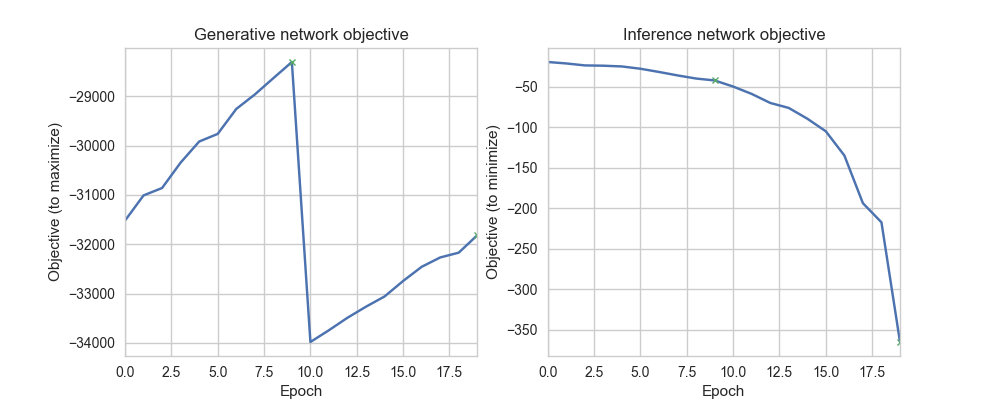

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
ax[0].plot(
    np.arange(len(generative_network_objective)),
    np.nan_to_num(generative_network_objective)
)
ax[0].plot(
    np.cumsum(num_generative_epochs) - 1,
    np.nan_to_num(np.array(generative_network_objective)[np.cumsum(num_generative_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[0].set_xlim([0, len(generative_network_objective) - 1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Objective (to maximize)')
ax[0].set_title('Generative network objective')

ax[1].plot(
    np.arange(len(inference_network_objective)),
    np.nan_to_num(inference_network_objective)
)
ax[1].plot(
    np.cumsum(num_inference_epochs) - 1,
    np.nan_to_num(np.array(inference_network_objective)[np.cumsum(num_inference_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[1].set_xlim([0, len(inference_network_objective) - 1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Objective (to minimize)')
ax[1].set_title('Inference network objective')

# Testing the Generative Model

<IPython.core.display.Javascript object>


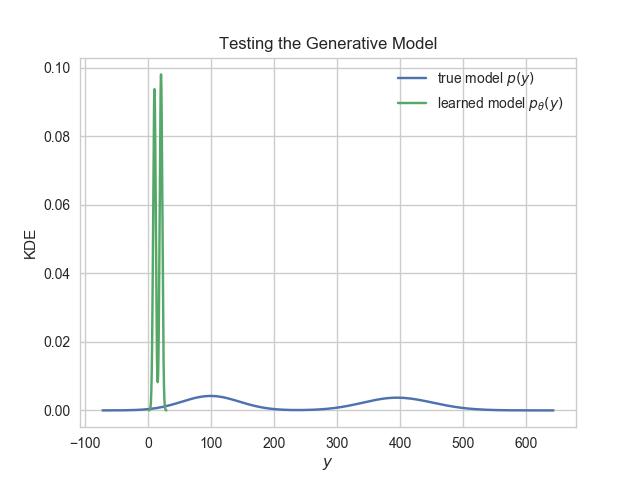

In [8]:
fig, ax = plt.subplots()
num_data = 1000

generative_model = quadratic.GenerativeModel()
_, _, y = generative_model.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='true model $p(y)$')

_, _, y = generative_network.sample(num_data)
y = y.squeeze(1).numpy()
sns.kdeplot(y, ax=ax, label='learned model $p_{\\theta}(y)$')

ax.set_ylabel('KDE')
ax.set_xlabel('$y$')
ax.set_title('Testing the Generative Model')

# Testing Inference

In [9]:
_, _, y_test = generative_model.sample(1)
y_test = generative_model.sample(1)[2][0][0]
y_test

128.27633666992188

<IPython.core.display.Javascript object>


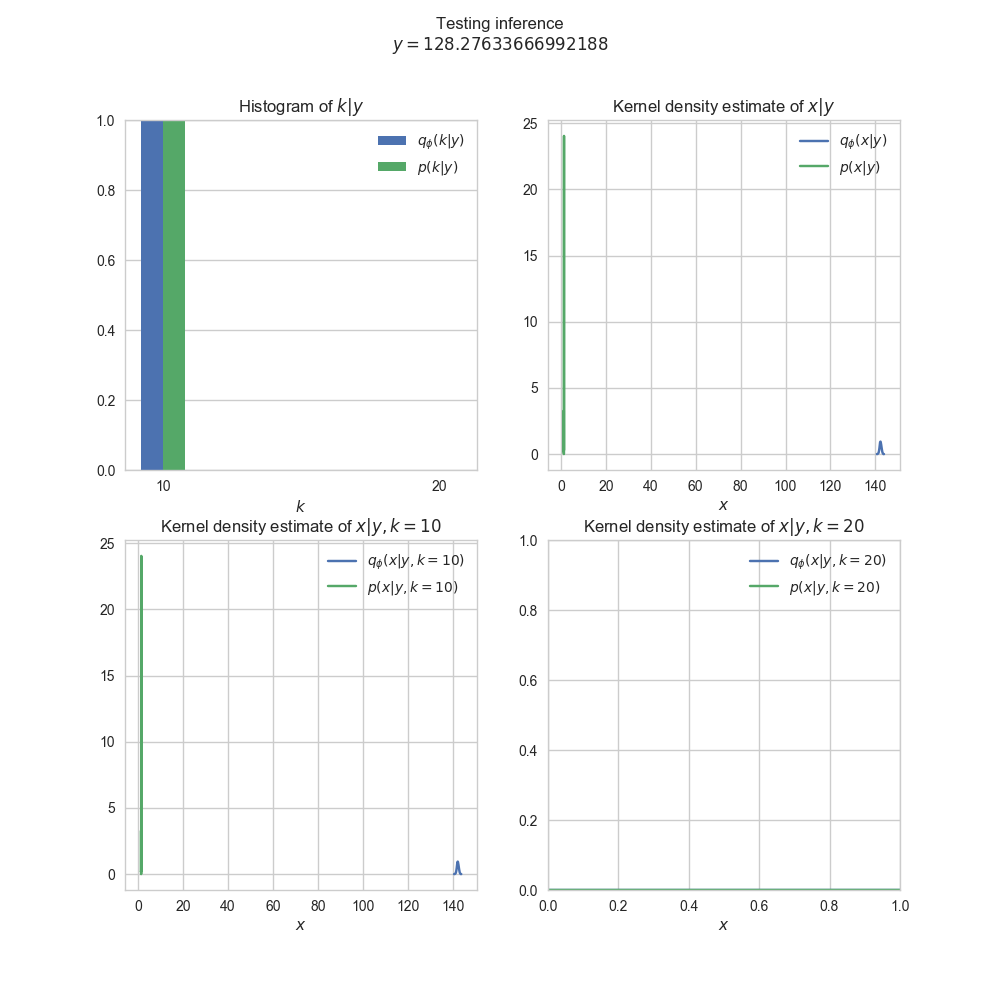

In [10]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Testing inference\n$y = {}$'.format(y_test))
bar_width = 0.8

##############
##############
##############

num_inference_network_samples = 1000
y = torch.Tensor([[y_test]]).expand(num_inference_network_samples, 1)
k, x = inference_network.sample(y)

values = [10, 20]
normalized_weights = [
    torch.sum(k == 10) / len(k),
    torch.sum(k == 20) / len(k),
]
bar1 = ax[0][0].bar(np.array(values) - bar_width / 2, normalized_weights, width=bar_width, tick_label=values, color=colors[0], label='$q_{\phi}(k | y)$')
sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1], label='$q_{\phi}(x | y)$', color=colors[0])

if len(x[k == 10]) != 0:
    sns.kdeplot(x[k == 10].view(-1).numpy(), ax=ax[1][0], label='$q_{\phi}(x | y, k = 10)$', color=colors[0])
else:
    ax[1][0].axhline(0, label='$q_{\phi}(x | y, k = 10)$', color=colors[0])

if len(x[k == 20]) != 0:
    sns.kdeplot(x[k == 20].view(-1).numpy(), ax=ax[1][1], label='$q_{\phi}(x | y, k = 20)$', color=colors[0])
else:
    ax[1][1].axhline(0, label='$q_{\phi}(x | y, k = 20)$', color=colors[0])

##############
##############
##############

num_particles = 100
num_posterior_samples = 100
k, x = generative_model.importance_sample(y_test, num_particles, resample=True, num_resample=num_posterior_samples)

values = [10, 20]
normalized_weights = [
    sum(k == 10) / len(k),
    sum(k == 20) / len(k),
]
bar2 = ax[0][0].bar(np.array(values) + bar_width / 2, normalized_weights, tick_label=values, label='$p(k | y)$', color=colors[1])

sns.distplot(x.numpy(), hist=False, ax=ax[0][1], label='$p(x | y)$', color=colors[1])

if normalized_weights[0] != 0:
    sns.distplot(
        x[k == 10].numpy(), 
        hist=False,
        ax=ax[1][0],
        label='$p(x | y, k = 10)$',
        color=colors[1]
    )
else:
    ax[1][0].axhline(0, label='$p(x | y, k = 10)$', color=colors[1])

if normalized_weights[1] != 0:
    sns.distplot(
        x[k == 20].numpy(), 
        hist=False,
        ax=ax[1][1],
        label='$p(x | y, k = 20)$',
        color=colors[1]
    )
else:
    ax[1][1].axhline(0, label='$p(x | y, k = 20)$', color=colors[1])

##############
##############
##############

ax[0][0].set_xticks(np.array([10, 20]))
ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $k | y$')
ax[0][0].set_xlabel('$k$')
ax[0][0].legend()

ax[0][1].set_title('Kernel density estimate of $x | y$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $x | y, k = 10$')
ax[1][0].set_xlabel('$x$')

ax[1][1].set_title('Kernel density estimate of $x | y, k = 20$')
ax[1][1].set_xlabel('$x$')
ax[1][1].legend()